# Laboratorium

### Konfiguracja

In [17]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [18]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


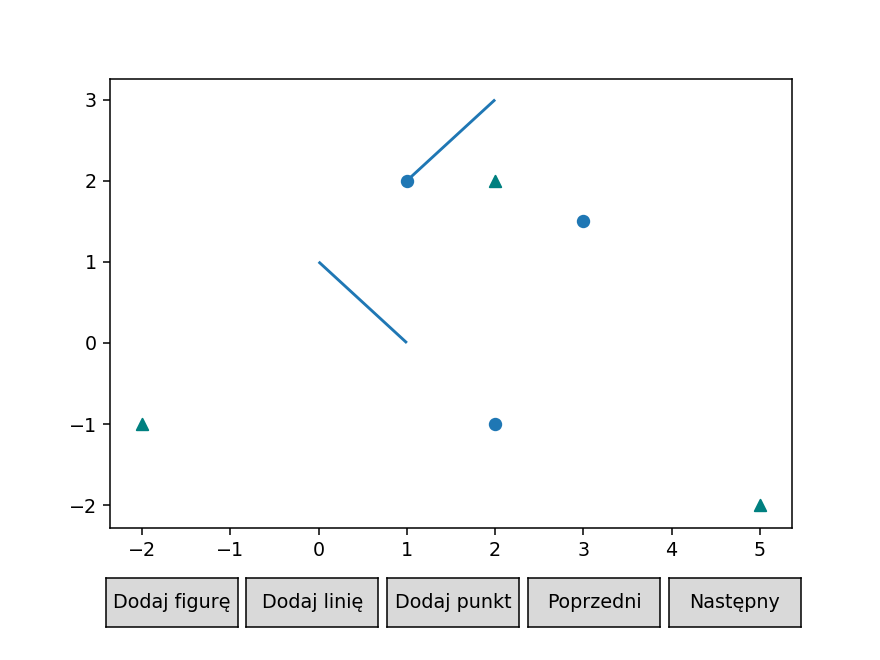

In [3]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='teal', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


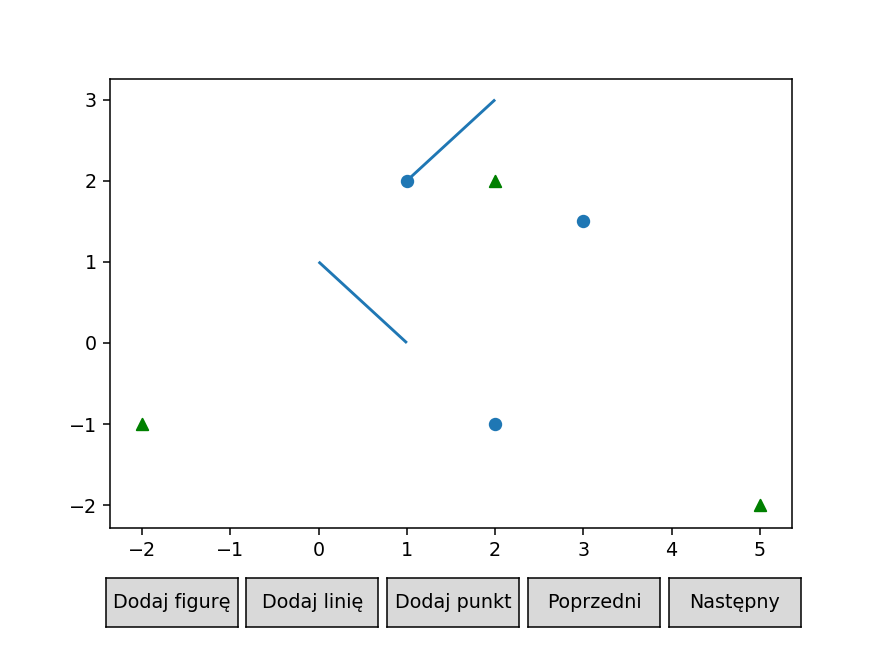

In [4]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


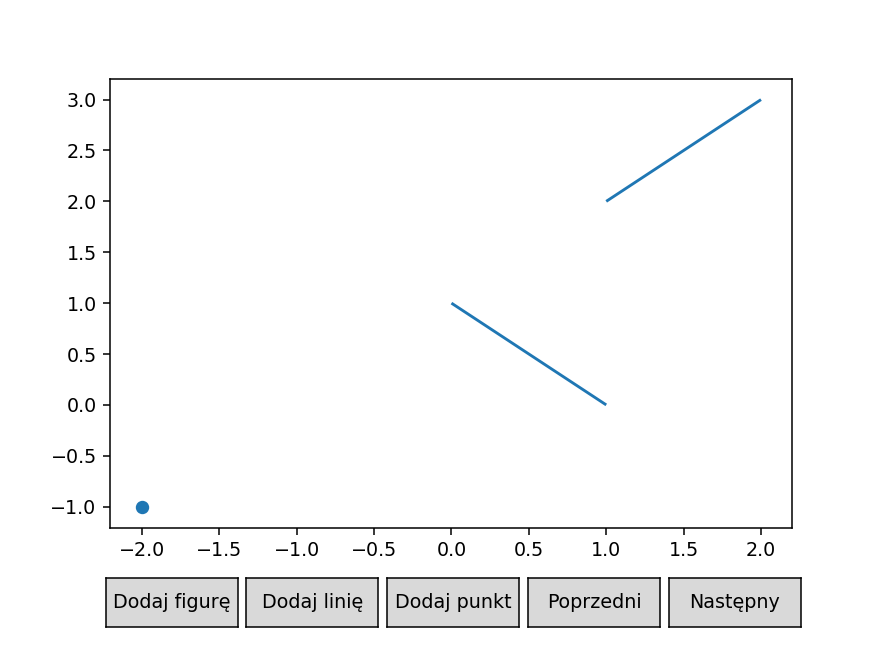

In [108]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


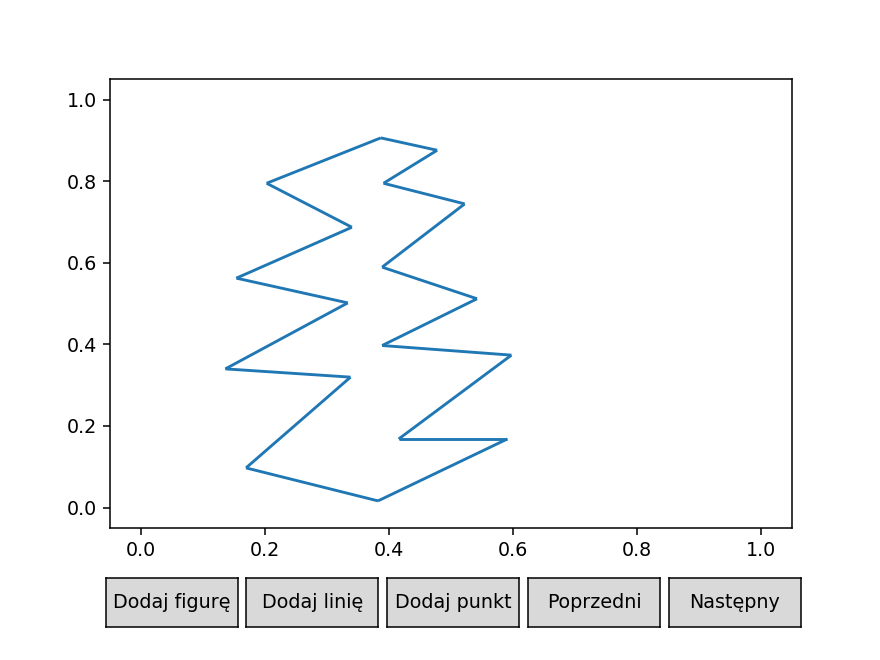

In [5]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

In [ ]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

<IPython.core.display.Javascript object>


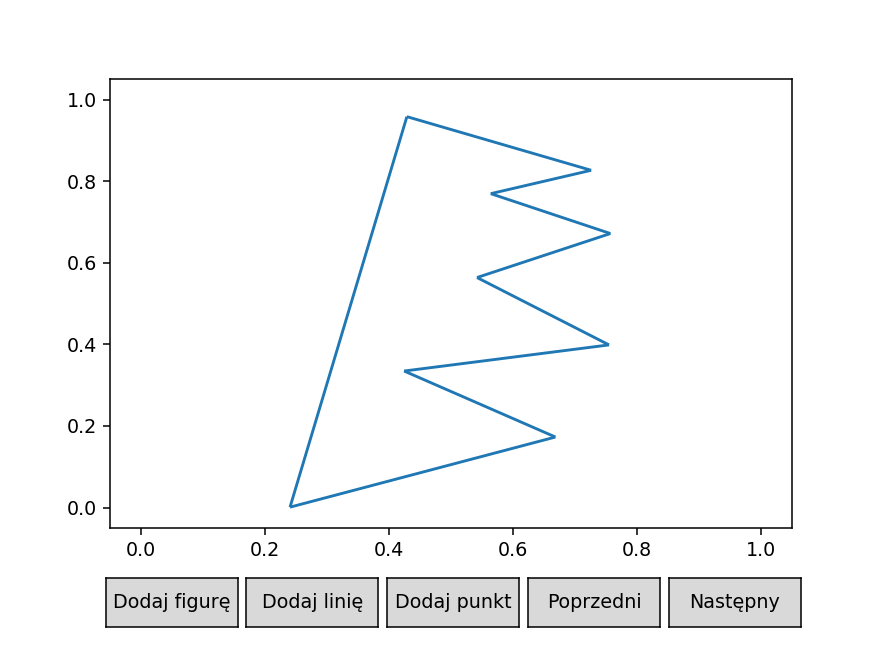

In [19]:
%matplotlib notebook
#Rysowanie punktow, z ktorych bedzie tworzony wielokat
plottest = Plot()
plottest.draw()

<IPython.core.display.Javascript object>


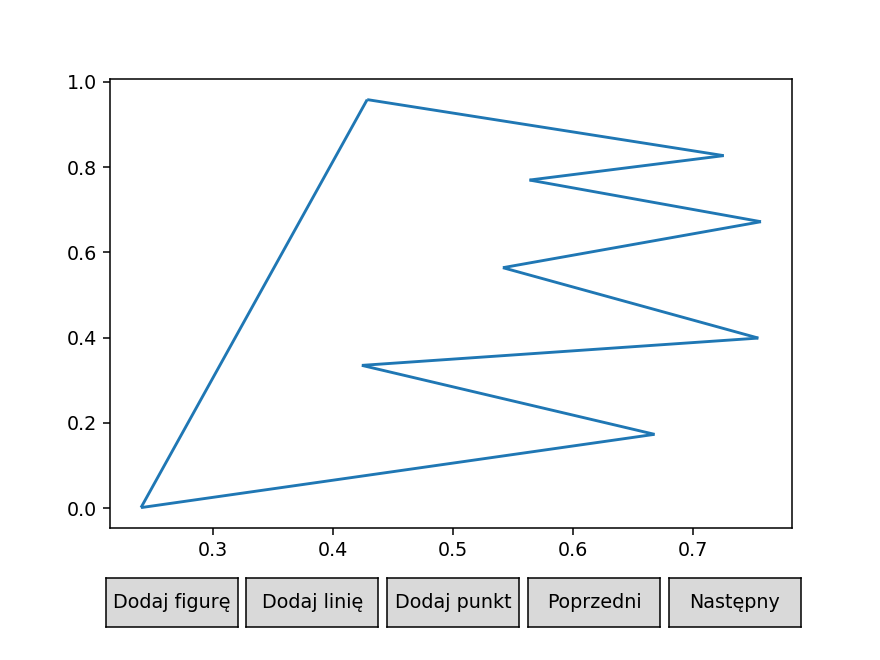

In [20]:
plot2 = Plot([plottest.get_added_elements()])

with open('wielokat.json', 'w') as file:
    file.write(plot2.toJson())
    
with open('wielokat.json', 'r') as file:
    json = file.read()
    
plot3 = Plot(json=json)
plot3.draw()

In [21]:
#Wyznacznik
def cross_prod(a,b,c):
    [ax,ay] = a
    [bx,by] = b
    [cx,cy] = c
    
    det = (ax*by + bx*cy + ay*cx) - (by*cx + ay*bx + cy*ax)
    
    return det

epsilon = 10**(-10)  #dokladnosc zera

In [22]:
#Uzyskanie linii z figury
def polygon_to_lines(figure):
    result = []
    for i in figure:
        result += i.lines
    return result


In [23]:
#Uzyskanie wspolrzednych punktow z linii - kolejne punkty to sasiedzi
def getingPointsFromLines(lines):
    result = []
    for line in lines:
        result += [line[0]]
        
    return result

In [24]:
class Point:
    def __init__(self,value,typeOf,color,side = None):
        self.value = value
        self.typeOf = typeOf
        self.color = color
        self.side = side

#Klasyfikacja punktow
#0 - poczatkowy - zielony
#1 - koncowy - czerwony ciemny
#2 - laczacy - zloty
#3 - dzielacy - cyjan
#4 - prawidlowy - ciemny zielony

#tworzac figure zawsze przeciwnie do wskazowek zegara:
#kat wewnetrzny < pi = idac po punktach w kolejnosci ich tworzenia skrecamy w lewo
#kat wewnetrzny > pi = idac po punktach w kolejnosci ich tworzenia skrecamy w prawo

def pointsClassification(points):
    result = []
    
    for i in range (len(points)):
        B = points[(len(points)+i-1)%(len(points))] #pointBefore
        N = points[i] #Now
        A = points[(i+1)%len(points)] #pointAfter
        
        det = cross_prod(B,N,A)
        
        if(B[1] < N[1]) and (A[1] < N[1]):   #jezeli wspolrzedne y punktu przed i po sa mniejsze od punktu aktualnie rozpatrywanego
            if det > epsilon:
                p = Point(N,0,"chartreuse") #startowy
            else:
                p = Point(N,3,"cyan") #dzielacy
        elif (B[1] > N[1]) and (A[1] > N[1]): #jezeli oboje sasiedzi sa powyzej
            if det > epsilon:
                p = Point(N,1,"crimson") #koncowy
            else:
                p = Point(N,2,"gold") #laczacy
        else:
            p = Point(N,4,"teal") #punkt prawidlowy
            
        result.append(p)
        
    return result

#Funkcje pomocnicze w kwestii rysowania wykresu figury wraz z kolorowaniem
def visualiserStatic(classifiedPoints,lines):
    
    points = []
    for point in classifiedPoints:
        points.append(PointsCollection([point.value],color = point.color))
        
    linescol = LinesCollection(lines)
    plot = Plot(points=points,
            lines=[LinesCollection(lines,color = 'black')])
    plot.draw()

def drawingPointsClassification(plot1):
    figure = plot1.get_added_figure()
    
    lines = polygon_to_lines(figure)
   
    points = getingPointsFromLines(lines)
    
    classifiedPoints = pointsClassification(points)
    
    visualiserStatic(classifiedPoints,lines)

In [25]:
#Wielokat jest y-monotoniczny, jezeli nie posiada wierzcholkow dzielacych i laczacych

def checkIfMonotonePolygon(figure):
    
    lines = polygon_to_lines(figure)
    
    points = getingPointsFromLines(lines)
    
    classifiedPoints = pointsClassification(points)
    
    for point in classifiedPoints:
        if point.typeOf == 2 or point.typeOf == 3: #jezeli zostal znaleziony punkt typu dzielacy lub laczacy  
            return False
    
    return True #jezeli wszystkie punkty sa poczatkowe/koncowe/prawidlowe

Liczba znalezionych trojkatow: 7
Trojkat   [(0.42885581601050604, 0.9581954563365265), (0.7260332353653448, 0.8267616328071148), (0.5641380740750221, 0.769469966140448)]
Trojkat   [(0.5641380740750221, 0.769469966140448), (0.757081622462119, 0.6717371230031932), (0.5419606547201834, 0.5638939857482911)]
Trojkat   [(0.42885581601050604, 0.9581954563365265), (0.5641380740750221, 0.769469966140448), (0.5419606547201834, 0.5638939857482911)]
Trojkat   [(0.5419606547201834, 0.5638939857482911), (0.7548638805266351, 0.39875918182672243), (0.4244203321395382, 0.33472731908162434)]
Trojkat   [(0.42885581601050604, 0.9581954563365265), (0.5419606547201834, 0.5638939857482911), (0.4244203321395382, 0.33472731908162434)]
Trojkat   [(0.24034775149437698, 0.001087613199271309), (0.6683719450427641, 0.17296261319927142), (0.4244203321395382, 0.33472731908162434)]
Trojkat   [(0.24034775149437698, 0.001087613199271309), (0.4244203321395382, 0.33472731908162434), (0.42885581601050604, 0.958195456336526

<IPython.core.display.Javascript object>


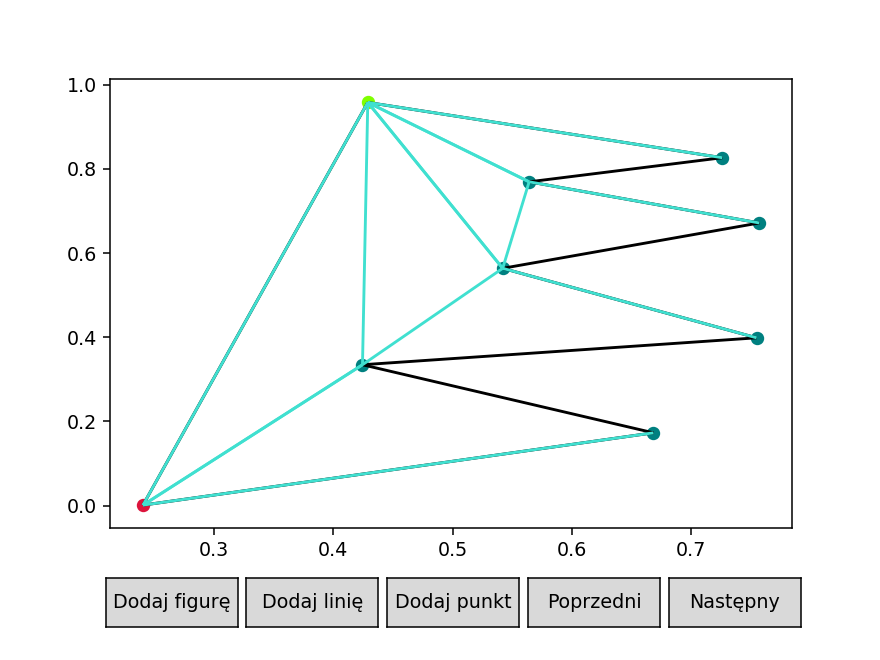

In [41]:
#Algorytm Triangulacji
#1 okreslenie lewego i prawego lancucha wielokata:
#mamy wieszcholki:
# na lewym lancuchu - -1
# na prawym lancuchu - 1
# wchodzace w sklad obu lancuchow, startowy i koncowy - 0

#struktura przechowujaca aktualny poziom triangulacji
class Triangulation:
    def __init__(self,points,lines):
        self.points = points
        self.lines = lines
        self.triangulationLines = []
        self.triangles = 0
        self.trianglesList = []
    
    #dodawanie linii do struktury
    def addLine(self,line):
        self.triangulationLines.append(line)
    
    def getTriangle(self,point,stackPoint1, stackPoint2):
        self.triangles+=1
        self.trianglesList.append([point.value,stackPoint1.value, stackPoint2.value])
        self.addLine([stackPoint1.value, point.value]) #dodajemy linie laczace punkt ze stosu i punkt badany
        self.addLine([stackPoint2.value, point.value])
        
    #do rysowania, zwraca aktualna scene triangulacji
    def getScene(self):
        pointsAll = []
        for point in self.points:
            pointsAll.append(PointsCollection([point.value],color = point.color))
            
        linesToShow = []
        for line in self.triangulationLines:
            linesToShow.append(line)
        
        lines = [LinesCollection(self.lines,color = 'black'),LinesCollection(linesToShow,color = 'turquoise')]
        scene = Scene(pointsAll,lines)
        
        return scene
        
        

def checkSides(points):
    
    #znalezienie punktu startowego
    i = 0 #indeks poruszajacy sie po liscie punktow
    
    while(points[i].typeOf != 0):
        i = (i+1)%(len(points))
        
    #zatrzymujemy sie na indeksie punktu startowego
    points[i].side = 0
    
    i = (i+1)%(len(points))
    while(points[i].typeOf != 1):
    #teraz idziemy az do punktu koncowego
    #idziemy kolejno z punktami - wiec przeciwnie do wskazowek zegara - wiec po lewej stronie wielokata
        points[i].side = -1 
        i = (i+1)%(len(points))
    
    #zatrzymujemy sie na punkcie koncowym - przypisujemy mu wiec 0
    points[i].side = 0
    
    #na koniec wracamy do punktu startowego
    while(points[i].typeOf != 1):
            
        points[i].side = 1 #idziemy po prawej stronie lancucha
        i = (i+1)%(len(points))
        
    return points

#konieczna bedzie rowniez funkcja pomocnicza do okreslania czy badany trojkat jest wewnatrz wielokata
def checkIfInside(a,b,c):
    det = cross_prod(a.value,b.value,c.value) #wyznaczamy wartosc wyznacznika
    
    if c.side == -1: #jezeli ostatni punkt jest po lewej stronie to by pozostac w srodku musimy skrecac w lewo
        return (det > epsilon)
    else:
        return (det < -epsilon) #jezeli jestesmy po prawej stronie to skrecamy w prawo

    
def triangulation(plot):
    
    scenes = [] #tu beda przechowywane kolejne sceny z trangulacji
    
    #z wykresu wyciagamy figure
    figure = plot.get_added_figure()
    
    if(not checkIfMonotonePolygon(figure)):
        return
    
    #z figury wyciagamy linie
    lines = polygon_to_lines(figure)
    
    #z linii wyciagamy punkty
    points = getingPointsFromLines(lines)
    
    #dokonujemy klasyfikacji punktow
    classifiedPoints = pointsClassification(points)
    
    #ustalamy, na ktorym lancuchu znajduja sie punkty
    classifiedPoints = checkSides(classifiedPoints)
    
    #porzadkujemy wierzcholki wzdluz kierunku monotonicznosci, a wiec w kierunku y
    classifiedPoints.sort(key = lambda x : x.value[1], reverse = True)
    
    #tworzymy strukture triangulacji
    triangles = Triangulation(classifiedPoints,lines)
    
    scenes.append(triangles.getScene())
    
    #stos
    stack = []
    
    #wkladamy 2 pierwsze wierzcholki na stos
    
    stack.append(classifiedPoints[0])
    stack.append(classifiedPoints[1])
    
    for i in range(2,len(classifiedPoints)):
        if(classifiedPoints[i].side != stack[-1].side): #sprawdzenie czy sa na tym samym lancuchu
            #dodajemy wszystkie mozliwe przekatne
            
            for k in range(len(stack)-1,0,-1):
                triangles.getTriangle(classifiedPoints[i],stack[k],stack[k-1])
                scenes.append(triangles.getScene())
                
            stack = [stack[-1],classifiedPoints[i]] #zostawiam ostatni element stosu i nowy punkt zamiatany
    
        else:
            new_stack = []  #stos pomocniczy
            while(len(stack)> 1):
                if(checkIfInside(stack[-2],stack[-1],classifiedPoints[i])):
                    triangles.getTriangle(stack[-2],stack[-1],classifiedPoints[i])
                    scenes.append(triangles.getScene())
                    stack.pop()
                else:
                    new_stack.append(stack.pop())
            
            new_stack.append(stack.pop())
            new_stack.reverse()
            new_stack.append(classifiedPoints[i])
            stack = new_stack 
            
    print("Liczba znalezionych trojkatow:", triangles.triangles)
    for t in triangles.trianglesList:
        print("Trojkat  " , t)
                
    return scenes
    
    
    
plot = Plot(scenes = triangulation(plottest))
plot.draw()


<IPython.core.display.Javascript object>


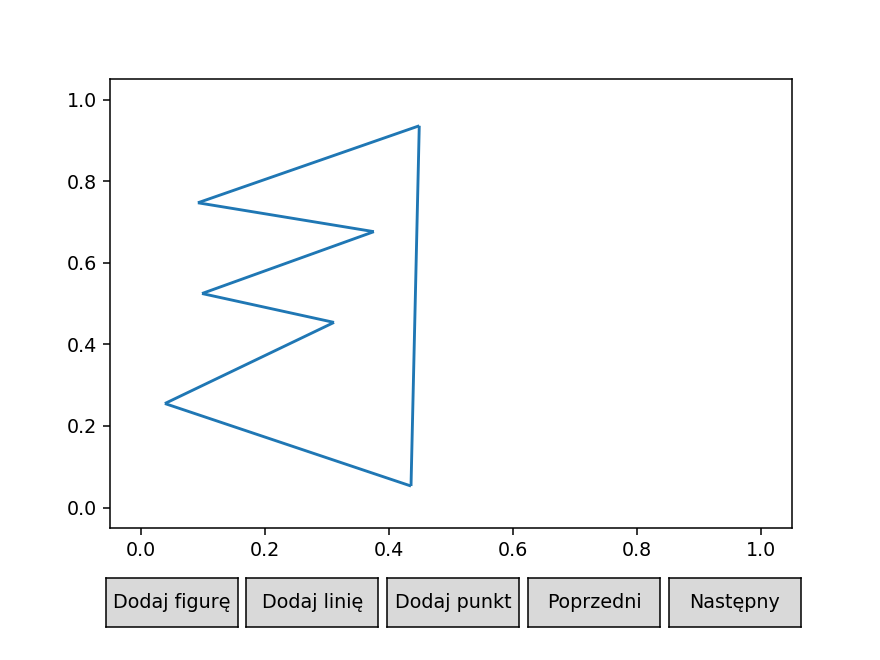

In [27]:
#Rozne Figury testowe


plot1 = Plot()
plot1.draw()

Liczba znalezionych trojkatow: 5
Trojkat   [(0.4488154934298608, 0.935830297657088), (0.0917590418169576, 0.7471048074610094), (0.37563000955889314, 0.6763327486374799)]
Trojkat   [(0.37563000955889314, 0.6763327486374799), (0.09841226762340921, 0.5246783368727741), (0.31131549342986087, 0.45390627804924466)]
Trojkat   [(0.4355090418169576, 0.052864611382577864), (0.03853323536534464, 0.25507049373551904), (0.31131549342986087, 0.45390627804924466)]
Trojkat   [(0.4355090418169576, 0.052864611382577864), (0.31131549342986087, 0.45390627804924466), (0.37563000955889314, 0.6763327486374799)]
Trojkat   [(0.4355090418169576, 0.052864611382577864), (0.37563000955889314, 0.6763327486374799), (0.4488154934298608, 0.935830297657088)]


<IPython.core.display.Javascript object>


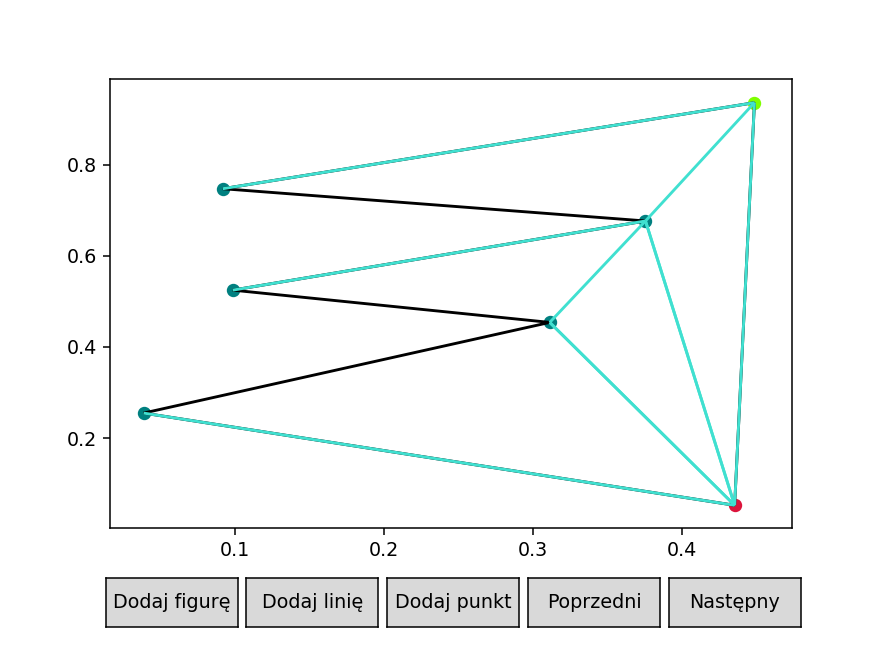

In [42]:
plot2 = Plot(scenes = triangulation(plot1))
plot2.draw()

<IPython.core.display.Javascript object>


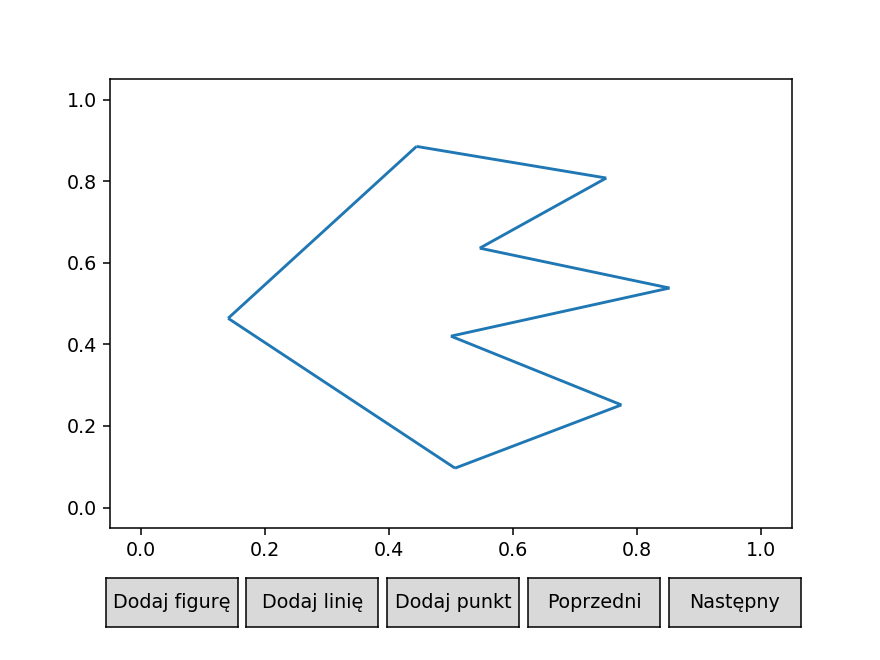

In [68]:
plot1 = Plot()
plot1.draw()

Liczba znalezionych trojkatow: 5
Trojkat   [(0.5042590418169577, 0.9327665815166402), (0.841355816010506, 0.7811121697519341), (0.5242187192363125, 0.5890165815166399)]
Trojkat   [(-0.001386119473365005, 0.4643229540656595), (0.5242187192363125, 0.5890165815166399), (0.5042590418169577, 0.9327665815166402)]
Trojkat   [(0.8103074289137319, 0.427251875634287), (-0.001386119473365005, 0.4643229540656595), (0.5242187192363125, 0.5890165815166399)]
Trojkat   [(-0.001386119473365005, 0.4643229540656595), (0.8103074289137319, 0.427251875634287), (0.4887348482685705, 0.28570775798722814)]
Trojkat   [(0.6240171063330867, 0.06328128739899275), (0.4887348482685705, 0.28570775798722814), (-0.001386119473365005, 0.4643229540656595)]


<IPython.core.display.Javascript object>


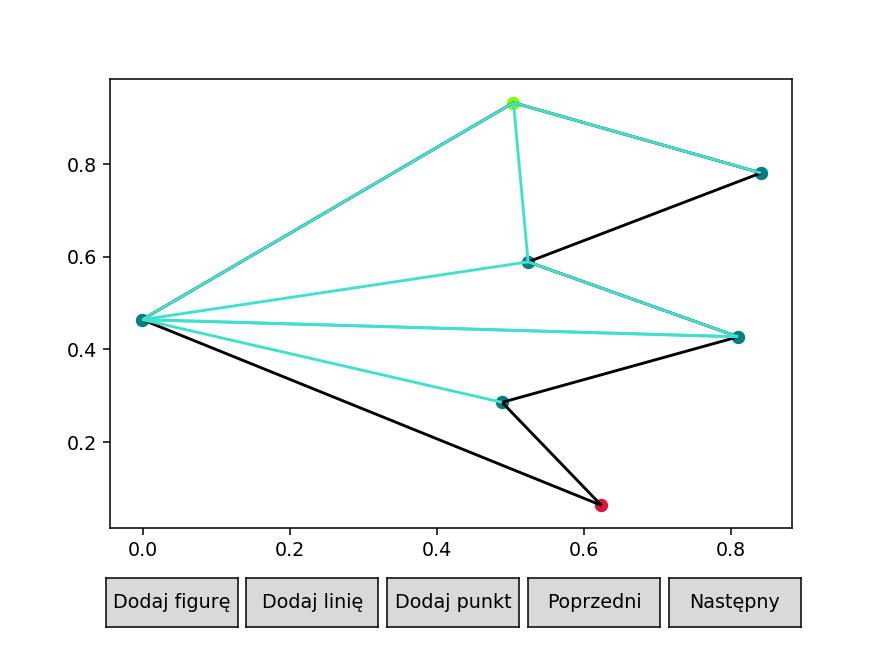

In [47]:
plot2 = Plot(scenes = triangulation(plot1))
plot2.draw()

<IPython.core.display.Javascript object>


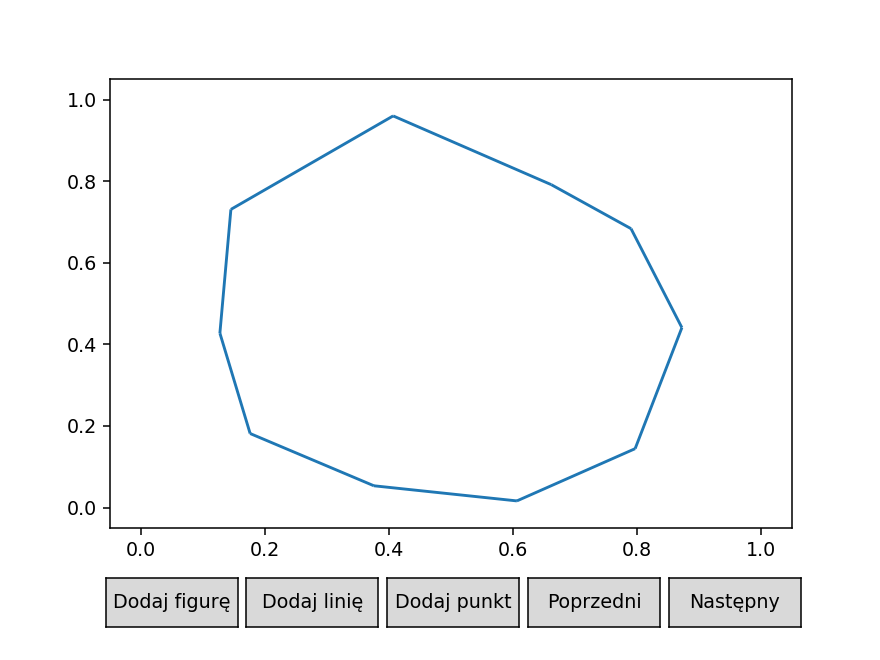

In [43]:
plot1 = Plot()
plot1.draw()

Liczba znalezionych trojkatow: 8
Trojkat   [(0.1449848482685705, 0.7308670296388515), (0.6617187192363125, 0.791528794344734), (0.4066783966556673, 0.9600336963055183)]
Trojkat   [(0.790347751494377, 0.683685657089832), (0.1449848482685705, 0.7308670296388515), (0.6617187192363125, 0.791528794344734)]
Trojkat   [(0.1449848482685705, 0.7308670296388515), (0.790347751494377, 0.683685657089832), (0.8724042031072802, 0.44103859826630243)]
Trojkat   [(0.1272429127846995, 0.4275582061094396), (0.8724042031072802, 0.44103859826630243), (0.1449848482685705, 0.7308670296388515)]
Trojkat   [(0.8724042031072802, 0.44103859826630243), (0.1272429127846995, 0.4275582061094396), (0.1760332353653447, 0.18154104924669445)]
Trojkat   [(0.7970009773008288, 0.14446997081532198), (0.1760332353653447, 0.18154104924669445), (0.8724042031072802, 0.44103859826630243)]
Trojkat   [(0.37563000955889314, 0.053477323756498385), (0.7970009773008288, 0.14446997081532198), (0.1760332353653447, 0.18154104924669445)]
Tr

<IPython.core.display.Javascript object>


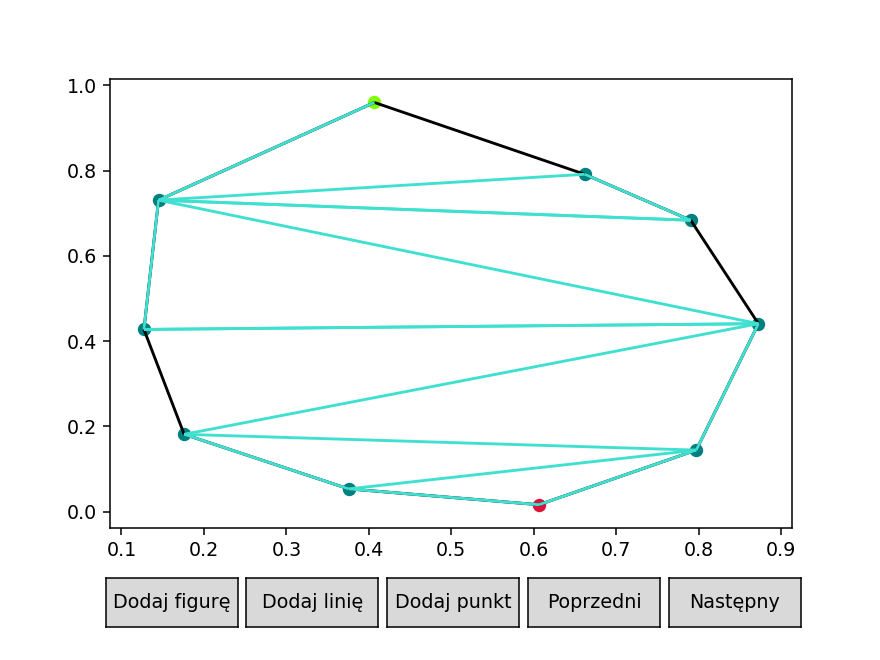

In [44]:
plot2 = Plot(scenes = triangulation(plot1))
plot2.draw()

<IPython.core.display.Javascript object>


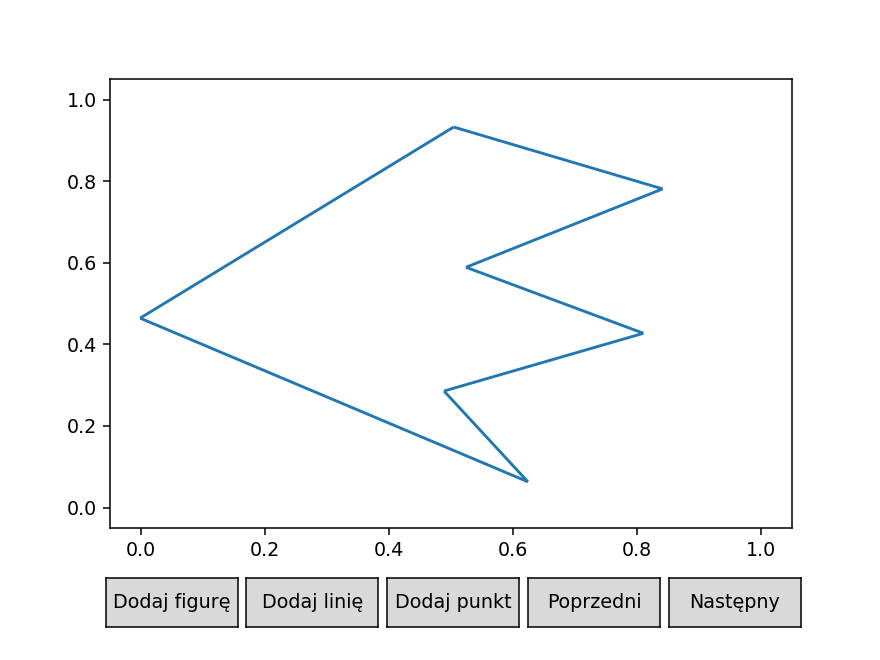

In [45]:
plot1 = Plot()
plot1.draw()

Liczba znalezionych trojkatow: 5
Trojkat   [(0.5042590418169577, 0.9327665815166402), (0.841355816010506, 0.7811121697519341), (0.5242187192363125, 0.5890165815166399)]
Trojkat   [(-0.001386119473365005, 0.4643229540656595), (0.5242187192363125, 0.5890165815166399), (0.5042590418169577, 0.9327665815166402)]
Trojkat   [(0.8103074289137319, 0.427251875634287), (-0.001386119473365005, 0.4643229540656595), (0.5242187192363125, 0.5890165815166399)]
Trojkat   [(-0.001386119473365005, 0.4643229540656595), (0.8103074289137319, 0.427251875634287), (0.4887348482685705, 0.28570775798722814)]
Trojkat   [(0.6240171063330867, 0.06328128739899275), (0.4887348482685705, 0.28570775798722814), (-0.001386119473365005, 0.4643229540656595)]


<IPython.core.display.Javascript object>


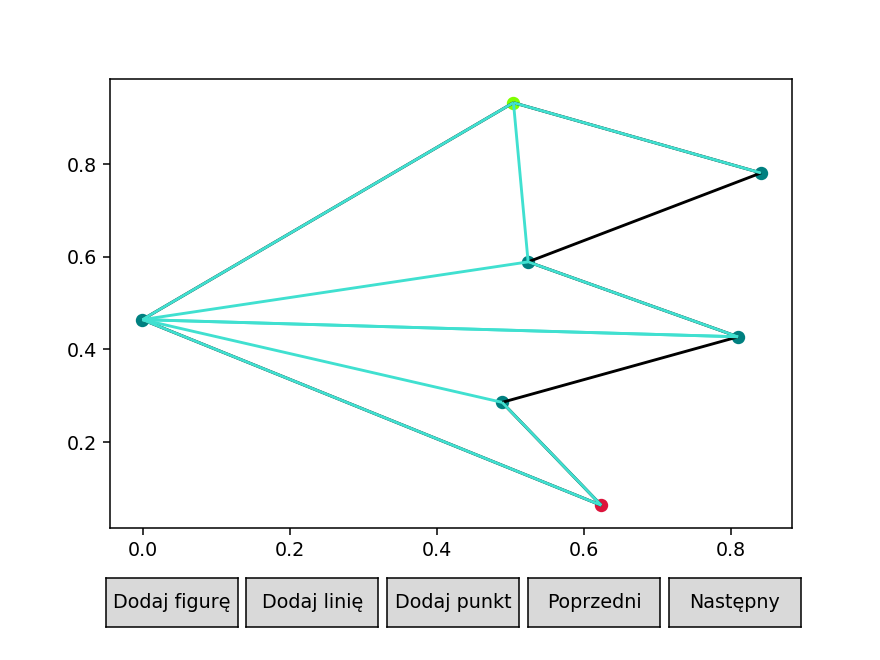

In [46]:
plot2 = Plot(scenes = triangulation(plot1))
plot2.draw()